In [1]:
# !pip install ricochet_env-0.1.0-cp37-cp37m-manylinux2010_x86_64.whl # use to install ricochet_env
!pip install gym
!pip install dopamine-rl

Processing ./ricochet_env-0.1.0-cp37-cp37m-manylinux2010_x86_64.whl
ricochet-env is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
import os
import numpy as np
import tensorflow.compat.v1 as tf
import gin
import gym
import dopamine
from dopamine.discrete_domains import run_experiment
from gym.envs.registration import register
from ricochet_env import RicochetEnv
from dopamine.discrete_domains.atari_lib import RainbowNetworkType

# from IPython.core.debugger import set_trace

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


/home/ADS/scca1033/.conda/envs/ricochet/lib/python3.7/site-packages/flax/nn/__init__.py:35: DeprecationWarning: The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md
  warnings.warn("The `flax.nn` module is Deprecated, use `flax.linen` instead. Learn more and find an upgrade guide at https://github.com/google/flax/blob/master/flax/linen/README.md", DeprecationWarning)


In [3]:
display(tf.config.list_physical_devices('CPU'))
display(tf.config.list_physical_devices('GPU'))
tf.test.is_built_with_cuda()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

[]

True

In [4]:
register(
    id = 'ricochet-easiest-v0',
    entry_point = 'ricochet_env:RicochetEnv',
    kwargs = {
        'board_size': 6,
        'walls': 'fixed',
        'targets': [(0, (4,4))],
        'robots': [(3,5), (2,0), (5,4), (3,2)],
        'seed': 23571113171923,
        'observation': "tensor"
    }
)

register(
    id = 'ricochet-small-random-robots-v0',
    entry_point = 'ricochet_env:RicochetEnv',
    kwargs = {
        'board_size': 6,
        'walls': 'fixed',
        'targets': [(0, (4,4))],
        'seed': 23571113171923,
        'observation': "tensor"
    }
)


register(
    id = 'ricochet-small-one-board-random-robots-v0',
    entry_point = 'ricochet_env:RicochetEnv',
    kwargs = {
        'board_size': 6,
        'walls': 1,
        'targets': "variants",
        'seed': 23571113171923,
        'observation': "tensor"
    }
)

register(
    id = 'ricochet-small-two-board-random-robots-v0',
    entry_point = 'ricochet_env:RicochetEnv',
    kwargs = {
        'board_size': 6,
        'walls': 2,
        'targets': "variants",
        'seed': 23571113171923,
        'observation': "tensor"
    }
)

register(
    id = 'ricochet-small-standard-v0',
    entry_point = 'ricochet_env:RicochetEnv',
    kwargs = {
        'board_size': 6,
        'walls': 32,
        'observation': 'tensor',
    }
)

register(
    id='ricochet-standard-v0',
    entry_point='ricochet_env:RicochetEnv',
)

The `ricochet-easiest-v0` can be solved in three moves.


    ┏━━━━┯━━━━┯━━━━┳━━━━┯━━━━┯━━━━┓
    ┃    │    │ br ┃    │    │    ┃    r* = red *
    ┠────┼────┼────╀────┼────┼────┨    b* = blue *
    ┃    │    │    │    │    │    ┃    g* = green *
    ┠────┼────┾━━━━╅────┼────┼────┨    y* = yellow *
    ┃    │    │    ┃ yr │    │    ┃    
    ┣━━━━┽────┼────╀────┼────┾━━━━┫    *r = * robot
    ┃    │    │    │    │    │    ┃    *t = * target
    ┠────┼────┼────┼────┾━━━━╅────┨
    ┃    │    │    │    │ rt ┃ gr ┃    st = spiral target
    ┠────┼────┼────╁────┼────╀────┨
    ┃    │    │    ┃ rr │    │    ┃
    ┗━━━━┷━━━━┷━━━━┻━━━━┷━━━━┷━━━━┛

Solution:

1. green down
2. red right
3. red up

In [5]:
BASE_PATH = './ricochet_runs'
LOG_PATH = os.path.join(BASE_PATH, 'tb_logs')
RAINBOW_PATH = os.path.join(BASE_PATH, 'ricochet-small-two-board-random-robots')

In [6]:
env = gym.make('ricochet-small-two-board-random-robots-v0')
gin.constant('OBSERVATION_SPACE', env.observation_space.shape)
gin.constant('OBSERVATION_TYPE', tf.int16)
gin.constant('BOARD_SIZE', env.board_size())
gin.constant('SUMMARY_WRITER', tf.summary.FileWriter(LOG_PATH))

'OBSERVATION_SPACE:'

(6, 6, 11)

'OBSERVATION_TYPE:'

tf.int16

'BOARD_SIZE:'

6

'SUMMARY_WRITER:'

In [7]:
@gin.configurable
class RainbowNetworkLocal(tf.keras.Model):
  """The network used to compute agent's return distributions."""

  def __init__(self, num_actions, num_atoms, support, name=None, board_size=None):
    """Creates the layers used calculating return distributions.
    Args:
      num_actions: int, number of actions.
      num_atoms: int, the number of buckets of the value function distribution.
      support: tf.linspace, the support of the Q-value distribution.
      name: str, used to crete scope for network parameters.
    """
    super(RainbowNetworkLocal, self).__init__(name=name)
    activation_fn = tf.keras.activations.relu
    regularizer = None
    size = board_size
    self.num_actions = num_actions
    self.num_atoms = num_atoms
    self.support = support
    # set_trace()
    self.kernel_initializer = tf.keras.initializers.VarianceScaling(
        scale=1.0 / np.sqrt(3.0), mode='fan_in', distribution='uniform')
    # Defining layers.

    self.conv1 = tf.keras.layers.Conv2D(
        33, [size, size], strides=2, padding='same', activation=activation_fn,
        kernel_initializer=self.kernel_initializer, name='Conv',
        input_shape=(size, size, 11), activity_regularizer=regularizer)
    self.norm1 = tf.keras.layers.BatchNormalization()
    self.max_pool1 = tf.keras.layers.MaxPooling2D(
        pool_size=2, strides=1, padding="same")
    self.conv2 = tf.keras.layers.Conv2D(
        66, [int(size/2), int(size/2)], strides=1, padding='same',
        activation=activation_fn, kernel_initializer=self.kernel_initializer,
        name='Conv', activity_regularizer=regularizer)
    self.norm2 = tf.keras.layers.BatchNormalization()
    self.max_pool2 = tf.keras.layers.MaxPooling2D(
        pool_size=2, strides=1, padding="same")
    self.flatten = tf.keras.layers.Flatten()
    self.dense1 = tf.keras.layers.Dense(
        512, activation=activation_fn,
        kernel_initializer=self.kernel_initializer, name='fully_connected')
    self.dense2 = tf.keras.layers.Dense(
        num_actions * num_atoms, kernel_initializer=self.kernel_initializer,
        name='fully_connected')

  def call(self, state):
    """
    Args:
      state: Tensor, input tensor.
    Returns:
      collections.namedtuple, output ops (graph mode) or output tensors (eager).
    """
    x = tf.cast(tf.squeeze(state, [4]), tf.float32)
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    x = self.norm2(x)
    x = self.max_pool2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    logits = tf.reshape(x, [-1, self.num_actions, self.num_atoms])
    probabilities = tf.keras.activations.softmax(logits)
    q_values = tf.reduce_sum(self.support * probabilities, axis=2)
    return RainbowNetworkType(q_values, logits, probabilities)

In [8]:
rainbow_config = """
import dopamine.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.atari_lib
import dopamine.discrete_domains.run_experiment
import dopamine.replay_memory.prioritized_replay_buffer
import gin.tf.external_configurables

RainbowAgent.observation_shape = %OBSERVATION_SPACE
RainbowAgent.observation_dtype = %OBSERVATION_TYPE
RainbowAgent.num_atoms = 51
RainbowAgent.stack_size = 1
RainbowAgent.network = @RainbowNetworkLocal
RainbowAgent.vmin = 0.
RainbowAgent.vmax = 1.
RainbowAgent.gamma = 0.99
RainbowAgent.update_horizon = 3
RainbowAgent.min_replay_history = 2000  # agent steps
RainbowAgent.update_period = 4
RainbowAgent.target_update_period = 1000  # agent steps
RainbowAgent.epsilon_train = 0.01
RainbowAgent.epsilon_eval = 0.001
RainbowAgent.epsilon_decay_period = 500000  # agent steps
RainbowAgent.replay_scheme = 'prioritized'
RainbowAgent.tf_device = '/gpu:0'  # use '/cpu:*' for non-GPU version
RainbowAgent.optimizer = @tf.train.AdamOptimizer()

RainbowNetworkLocal.board_size = %BOARD_SIZE


tf.train.AdamOptimizer.learning_rate = 0.0005
tf.train.AdamOptimizer.epsilon = 0.00000001


create_gym_environment.environment_name = 'ricochet-small-two-board-random-robots'
create_gym_environment.version = 'v0'
create_agent.agent_name = 'rainbow'
# create_agent.summary_writer = %SUMMARY_WRITER
# create_agent.debug_mode = True
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 500
Runner.training_steps = 10000  # agent steps
Runner.evaluation_steps = 100  # agent steps
Runner.max_steps_per_episode = 5000  # agent steps

WrappedPrioritizedReplayBuffer.replay_capacity = 100000
WrappedPrioritizedReplayBuffer.batch_size = 32
"""
gin.parse_config(rainbow_config, skip_unknown=False)

([],
 ['dopamine.agents.rainbow.rainbow_agent',
  'dopamine.discrete_domains.atari_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.replay_memory.prioritized_replay_buffer',
  'gin.tf.external_configurables'])

In [9]:
%load_ext tensorboard
%load_ext autoreload
%matplotlib inline
%tensorboard --logdir RAINBOW_PATH/logs

Reusing TensorBoard on port 6006 (pid 3556396), started 11:57:36 ago. (Use '!kill 3556396' to kill it.)

In [10]:
%%timeit -n1 -r1

dqn_runner = run_experiment.create_runner(RAINBOW_PATH, schedule='continuous_train')
print('Will train Rainbow agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

6

6

Will train Rainbow agent, please be patient, may be a while...
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


KeyboardInterrupt: 

Reading statistics from: ./ricochet_runs/rainbow-easy-random-robots//logs/log_237
Index(['iteration', 'train_episode_lengths', 'train_episode_returns',
       'train_average_return', 'run'],
      dtype='object')


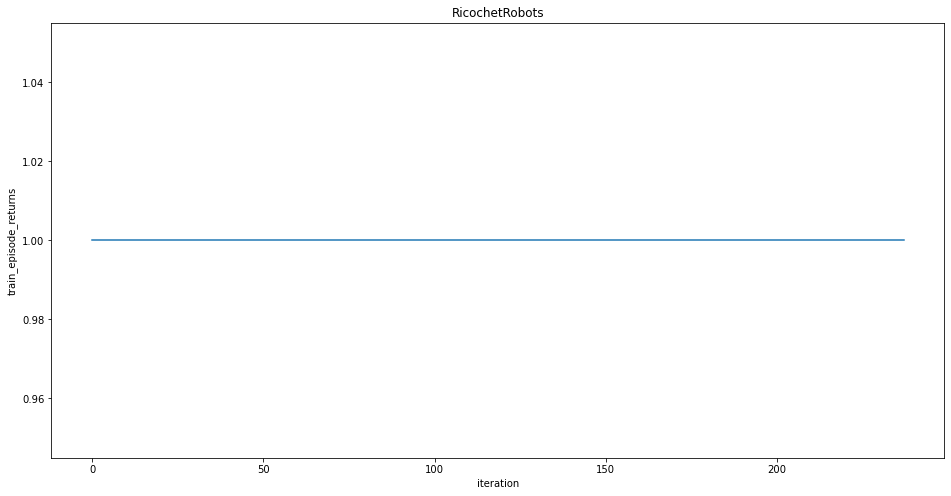

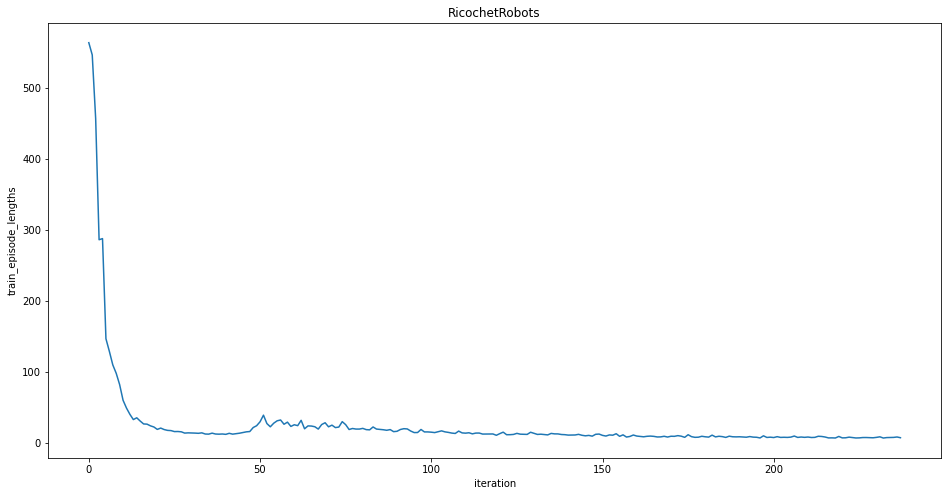

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from dopamine.colab import utils as colab_utils

data = colab_utils.read_experiment(RAINBOW_PATH, verbose=True, 
                                   summary_keys=['train_episode_lengths',
                                                 'train_episode_returns',
                                                 'train_average_return'])
data['run'] = 1

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='iteration', y='train_episode_returns', data=data, ax=ax)
plt.title('RicochetRobots')
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='iteration', y='train_episode_lengths', data=data, ax=ax)
plt.title('RicochetRobots')
plt.show()

In [17]:
import pandas as pd
data.to_csv(os.path.join(RAINBOW_PATH, 'data.csv'))